# Memory and RAG

将记忆和RAG设计为两个独立的工具memory_tool和rag_tool
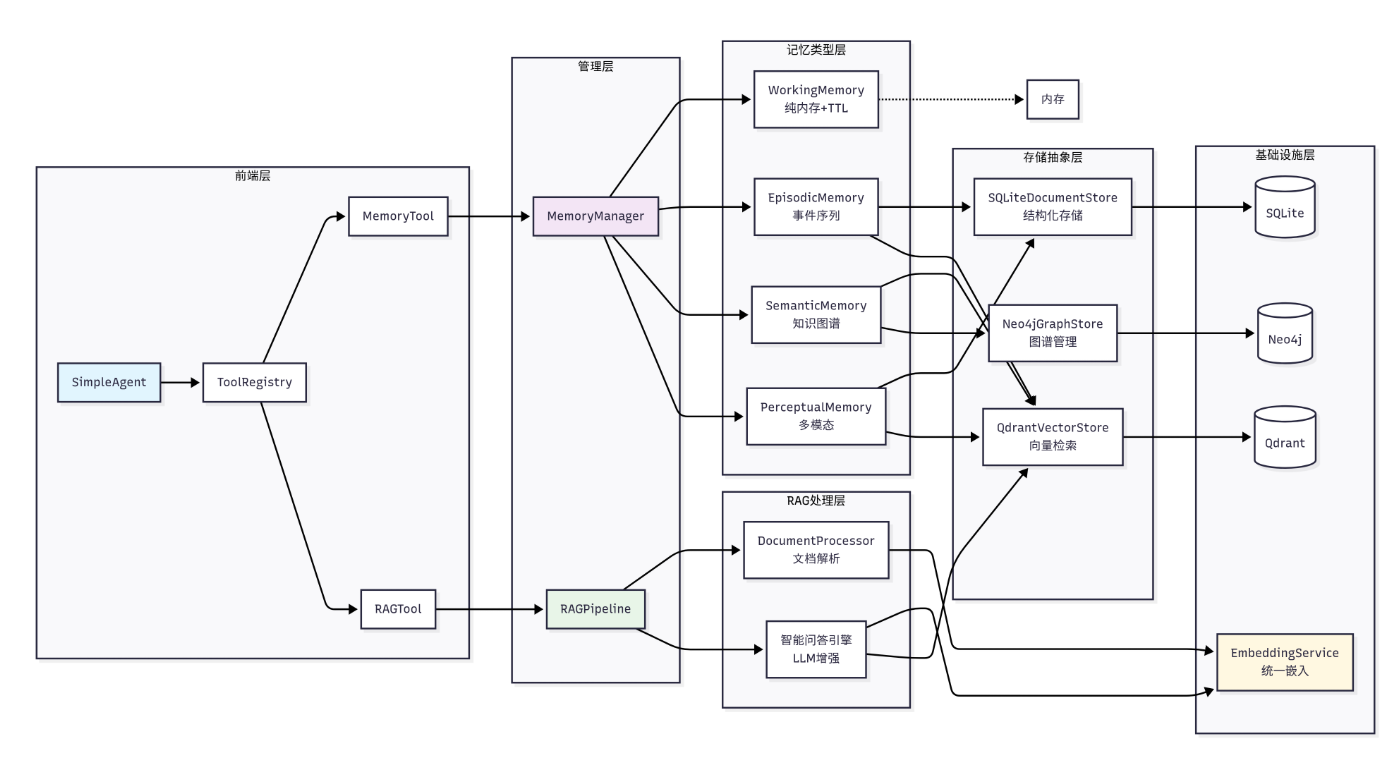

```markdown
HelloAgents记忆系统
├── 基础设施层 (Infrastructure Layer)
│   ├── MemoryManager - 记忆管理器（统一调度和协调）
│   ├── MemoryItem - 记忆数据结构（标准化记忆项）
│   ├── MemoryConfig - 配置管理（系统参数设置）
│   └── BaseMemory - 记忆基类（通用接口定义）
├── 记忆类型层 (Memory Types Layer)
│   ├── WorkingMemory - 工作记忆（临时信息，TTL管理）
│   ├── EpisodicMemory - 情景记忆（具体事件，时间序列）
│   ├── SemanticMemory - 语义记忆（抽象知识，图谱关系）
│   └── PerceptualMemory - 感知记忆（多模态数据）
├── 存储后端层 (Storage Backend Layer)
│   ├── QdrantVectorStore - 向量存储（高性能语义检索）
│   ├── Neo4jGraphStore - 图存储（知识图谱管理）
│   └── SQLiteDocumentStore - 文档存储（结构化持久化）
└── 嵌入服务层 (Embedding Service Layer)
    ├── DashScopeEmbedding - 通义千问嵌入（云端API）
    ├── LocalTransformerEmbedding - 本地嵌入（离线部署）
    └── TFIDFEmbedding - TFIDF嵌入（轻量级兜底）
```

```markdown
HelloAgents RAG系统
├── 文档处理层 (Document Processing Layer)
│   ├── DocumentProcessor - 文档处理器（多格式解析）
│   ├── Document - 文档对象（元数据管理）
│   └── Pipeline - RAG管道（端到端处理）
├── 嵌入表示层 (Embedding Layer)
│   └── 统一嵌入接口 - 复用记忆系统的嵌入服务
├── 向量存储层 (Vector Storage Layer)
│   └── QdrantVectorStore - 向量数据库（命名空间隔离）
└── 智能问答层 (Intelligent Q&A Layer)
    ├── 多策略检索 - 向量检索 + MQE + HyDE
    ├── 上下文构建 - 智能片段合并与截断
    └── LLM增强生成 - 基于上下文的准确问答

hello-agents/
├── hello_agents/
│   ├── memory/                   # 记忆系统模块
│   │   ├── base.py               # 基础数据结构（MemoryItem, MemoryConfig, BaseMemory）
│   │   ├── manager.py            # 记忆管理器（统一协调调度）
│   │   ├── embedding.py          # 统一嵌入服务（DashScope/Local/TFIDF）
│   │   ├── types/                # 记忆类型实现
│   │   │   ├── working.py        # 工作记忆（TTL管理，纯内存）
│   │   │   ├── episodic.py       # 情景记忆（事件序列，SQLite+Qdrant）
│   │   │   ├── semantic.py       # 语义记忆（知识图谱，Qdrant+Neo4j）
│   │   │   └── perceptual.py     # 感知记忆（多模态，SQLite+Qdrant）
│   │   ├── storage/              # 存储后端实现
│   │   │   ├── qdrant_store.py   # Qdrant向量存储（高性能向量检索）
│   │   │   ├── neo4j_store.py    # Neo4j图存储（知识图谱管理）
│   │   │   └── document_store.py # SQLite文档存储（结构化持久化）
│   │   └── rag/                  # RAG系统
│   │       ├── pipeline.py       # RAG管道（端到端处理）
│   │       └── document.py       # 文档处理器（多格式解析）
│   └── tools/builtin/            # 扩展内置工具
│       ├── memory_tool.py        # 记忆工具（Agent记忆能力）
│       └── rag_tool.py           # RAG工具（智能问答能力）
└──

```


In [1]:
# 配置好同级文件夹下.env中的大模型API
from hello_agents import SimpleAgent, HelloAgentsLLM, ToolRegistry
from hello_agents.tools import MemoryTool, RAGTool
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
print(torch.__version__)
print("cuda:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())


OSError: [WinError 127] 找不到指定的程序。 Error loading "d:\conda_envs\research-agent\Lib\site-packages\torch\lib\shm.dll" or one of its dependencies.

In [ ]:

# 创建LLM实例
llm = HelloAgentsLLM()

# 创建Agent
agent = SimpleAgent(
    name="智能助手",
    llm=llm,
    system_prompt="你是一个有记忆和知识检索能力的AI助手"
)

# 创建工具注册表
tool_registry = ToolRegistry()

# 添加记忆工具
memory_tool = MemoryTool(user_id="user123")
tool_registry.register_tool(memory_tool)

# 添加RAG工具
rag_tool = RAGTool(knowledge_base_path="./knowledge_base")
tool_registry.register_tool(rag_tool)

# 为Agent配置工具
agent.tool_registry = tool_registry

# 开始对话
response = agent.run("你好！请记住我叫张三，我是一名Python开发者")
print(response)


## 记忆系统：让智能体拥有记忆

### 记忆系统的工作流程
已知人类的记忆形成包括以下阶段：
1. 编码（Encoding）
2. 存储（Storage）
3. 检索（Retrieval）
4. 整合（Consolidation）
5. 遗忘（Forgetting）
基于该启发，设计了一套完整的记忆系统
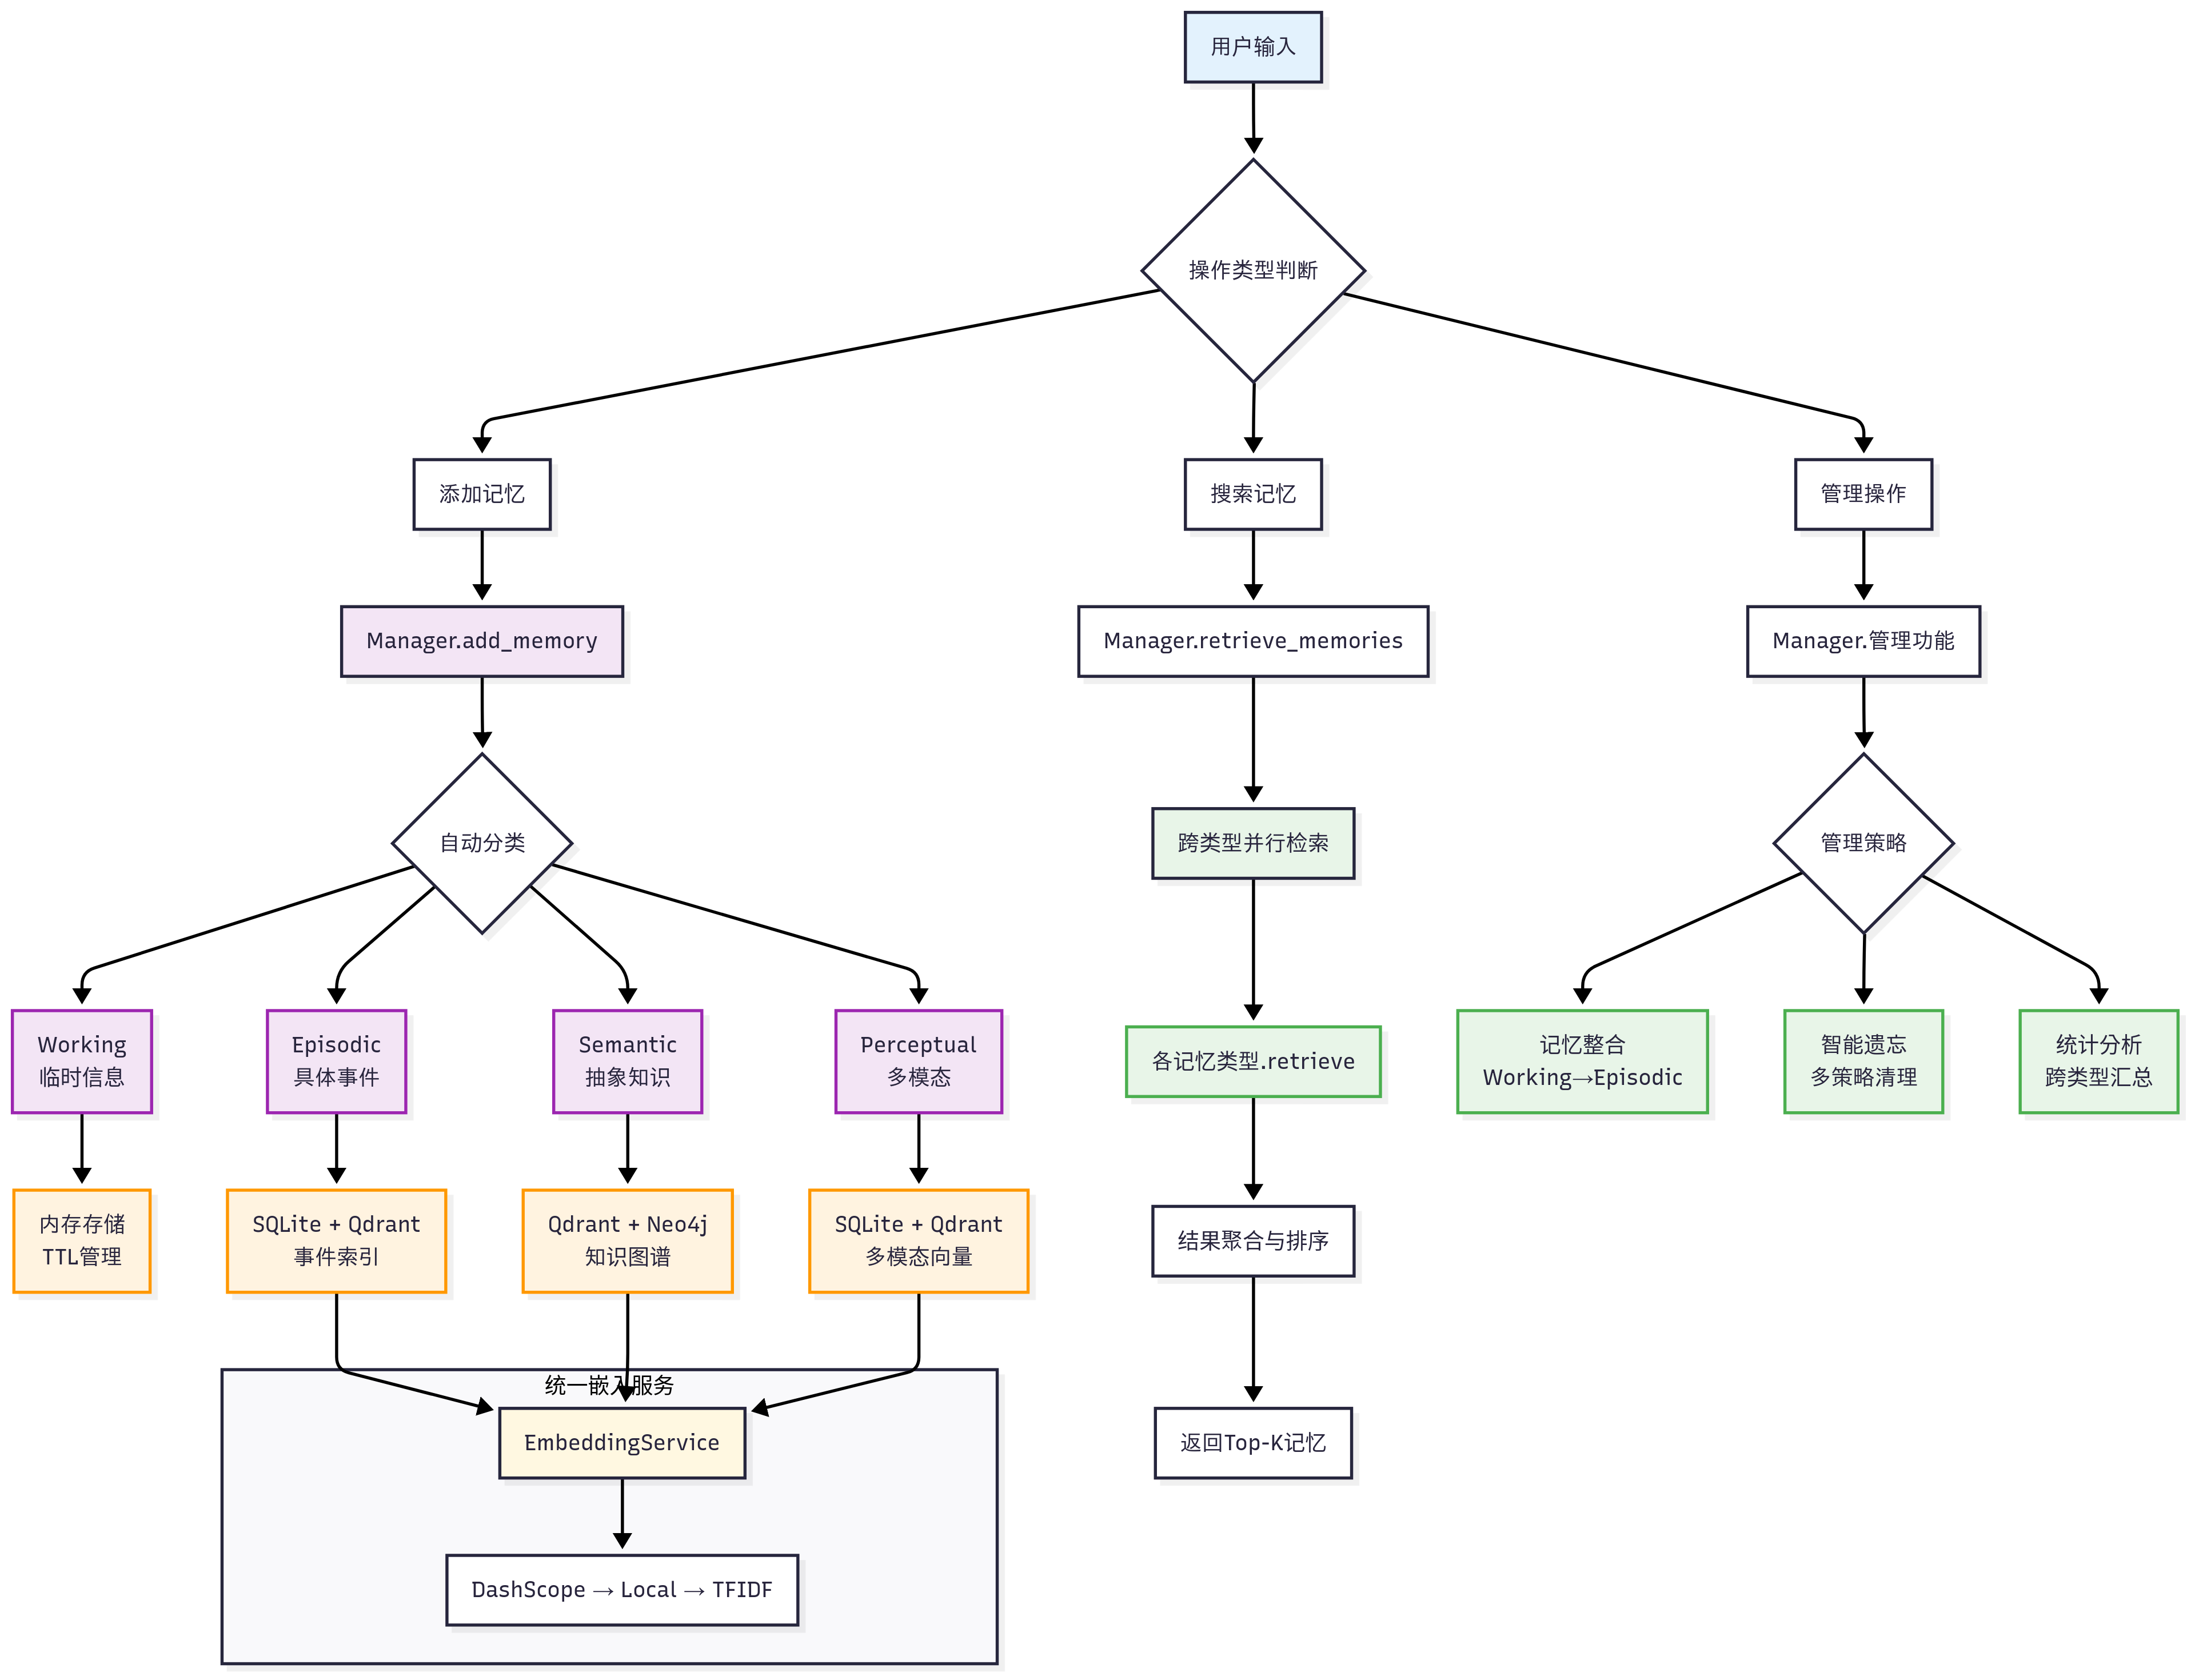